In [1]:
import numpy as np, time, random

print(time.strftime("%H:%M:%S"))
random.seed(24)


19:49:14


In [2]:
from gammabayes.likelihoods.irfs import IRF_LogLikelihood
from gammabayes.utils.config_utils import (
    read_config_file, 
    create_true_axes_from_config, 
    create_recon_axes_from_config, 
)
from gammabayes.utils import (
    dynamic_import
)
from matplotlib import pyplot as plt

config_file_path = 'ConfigFiles/HyperParameterInference_config.yaml'
config_dict = read_config_file(config_file_path)

source_hyperparameter_input = config_dict['parameter_specifications']
mixture_bounds               = [config_dict['mixture_fraction_specifications'][mixture]['bounds'] for mixture in config_dict['mixture_fraction_specifications']]

NumEvents                   = config_dict['Nevents']
truemass                    = config_dict['dark_matter_mass']
signal_fraction             = config_dict['signal_fraction']
ccr_of_bkg_fraction         = config_dict['ccr_of_bkg_fraction']
diffuse_of_astro_fraction   = config_dict['diffuse_of_astro_fraction']

nsig = int(round(signal_fraction*NumEvents))
nccr = int(round((1-signal_fraction)*ccr_of_bkg_fraction*NumEvents))
ndiffuse = int(round((1-signal_fraction)*(1-ccr_of_bkg_fraction)*diffuse_of_astro_fraction*NumEvents))
nlocal = int(round((1-signal_fraction)*(1-ccr_of_bkg_fraction)*(1-diffuse_of_astro_fraction)*NumEvents))


if nsig+nccr+ndiffuse+nlocal!=NumEvents:
    print(nsig, nccr, ndiffuse, nlocal)

assert nsig+nccr+ndiffuse+nlocal==NumEvents

file path: ConfigFiles/HyperParameterInference_config.yaml


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
energy_true_axis,  longitudeaxistrue, latitudeaxistrue       = create_true_axes_from_config(config_dict)
energy_recon_axis, longitudeaxis,     latitudeaxis           = create_recon_axes_from_config(config_dict)


irf_loglike = IRF_LogLikelihood(axes   =   [energy_recon_axis,    longitudeaxis,     latitudeaxis], 
                                dependent_axes =   [energy_true_axis,     longitudeaxistrue, latitudeaxistrue],
                                prod_vers='5') # or '3b'/3/'3'

# log_psf_normalisations, log_edisp_normalisations = irf_loglike.create_log_norm_matrices()
# irf_norm_matrix = log_psf_normalisations + log_edisp_normalisations
irf_norm_matrix = np.zeros(shape=(energy_true_axis.size,  
                                  longitudeaxistrue.size, 
                                  latitudeaxistrue.size))

0.2 90.0 100 0.1 -3.0 3.0 -3.0 3.0
0.2 90.0 50 0.1 -3.0 3.0 -3.0 3.0

Path to irf fits file: /Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/utils/../package_data/irf_fits_files/prod5/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz

Number of input dimensions 3


In [4]:
# np.save('irf_norm_matrix.npy', irf_norm_matrix)
# irf_norm_matrix = np.load('irf_norm_matrix.npy')
irf_norm_matrix.shape

(266, 61, 61)

In [5]:
from gammabayes.likelihoods import DiscreteLogLikelihood
from gammabayes.priors.astro_sources import (
    construct_hess_source_map, 
    construct_fermi_gaggero_matrix, 
    construct_hess_source_map_interpolation, 
    construct_log_fermi_gaggero_bkg,
)
from gammabayes.dark_matter import CombineDMComps
from gammabayes.dark_matter.density_profiles import Einasto_Profile

from gammabayes.priors import DiscreteLogPrior, log_bkg_CCR_dist, TwoCompPrior
dark_matter_spectral_class = dynamic_import('gammabayes.dark_matter.spectral_models', config_dict['dark_matter_spectral_model'])

In [6]:
DM_prior = TwoCompPrior(name='Z2 Scalar Singlet dark matter',
                        spectral_class = dark_matter_spectral_class, 
                        spectral_class_kwds={'ratios':True},
                        spatial_class = Einasto_Profile,
                        irf_loglike=irf_loglike, 
                        axes=(energy_true_axis, 
                              longitudeaxistrue, 
                              latitudeaxistrue,), 
                        axes_names=['energy', 'lon', 'lat'],
                        default_spectral_parameters={
                            'mass':config_dict['dark_matter_mass'],
                            'lahS':0.1}, )

In [7]:
ccr_bkg_prior = DiscreteLogPrior(logfunction=log_bkg_CCR_dist, name='CCR Mis-identification Background',
                               axes=(   energy_true_axis, 
                                        longitudeaxistrue, 
                                        latitudeaxistrue,), 
                                    axes_names=['energy', 'lon', 'lat'], )


from gammabayes.priors.astro_sources import FermiGaggeroDiffusePrior, HESSCatalogueSources_Prior
diffuse_astro_bkg_prior = FermiGaggeroDiffusePrior(energy_axis=energy_true_axis, longitudeaxis=longitudeaxistrue, latitudeaxis=latitudeaxistrue, irf=irf_loglike)
point_astro_bkg_prior = HESSCatalogueSources_Prior(energy_axis=energy_true_axis, longitudeaxis=longitudeaxistrue, latitudeaxis=latitudeaxistrue, irf=irf_loglike)


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/priors/core/discrete_logprior.py:64: UserWarning: No function to calculate on mesh efficiently given
  warnings.warn('No function to calculate on mesh efficiently given')
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/priors/core/discrete_logprior.py:64: UserWarning: No function to calculate on mesh efficiently given
  warnings.warn('No function to calculate on mesh efficiently given')
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/priors/core/discrete_logprior.py:64: UserWarning: No function to calculate on mesh efficiently given
  warnings.warn('No function to calculate on mesh efficiently given')


In [8]:
def proposal_func(energy, longitude, latitude, spectral_parameters={}, spatial_parameters={}):
    return np.log(energy**(-1))

proposal_prior = DiscreteLogPrior(logfunction          =   proposal_func,
                                       name                 =   'Proposal',
                                       axes                 =   (energy_true_axis, 
                                                                 longitudeaxistrue, 
                                                                 latitudeaxistrue,), 
                                       axes_names           =    ['energy', 'lon', 'lat'], )

# Simulations

In [9]:
sig_event_data  = DM_prior.sample(nsig)
ccr_event_data  = ccr_bkg_prior.sample(nccr)
diffuse_event_data  = diffuse_astro_bkg_prior.sample(ndiffuse)
point_event_data  = point_astro_bkg_prior.sample(nlocal)

['CCR Mis-identification Background']
['Fermi-Gaggero Diffuse Astrophysical Prior']
['HESS Catalogue Sources Prior']
['Z2 Scalar Singlet dark matter']


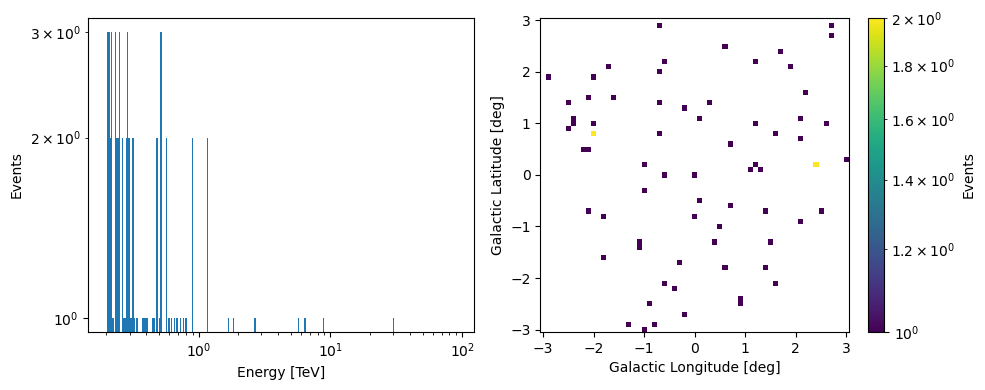

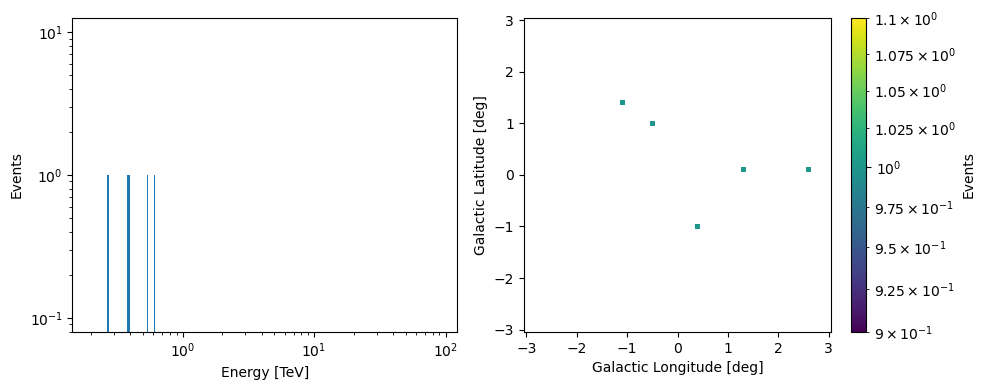

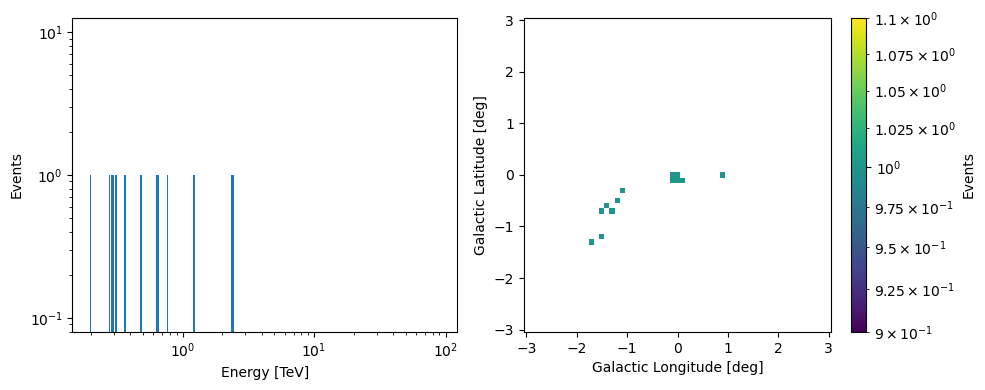

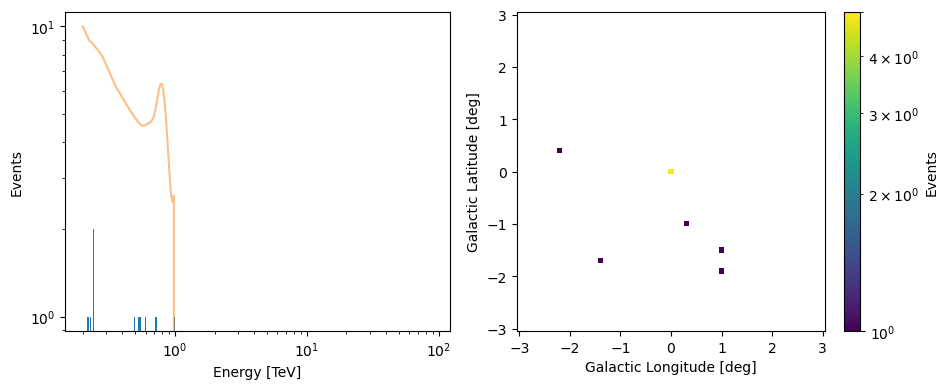

In [10]:
for source_idx, event_data in enumerate([ccr_event_data, diffuse_event_data, point_event_data, sig_event_data]):
    print(np.unique(event_data._source_ids))
    fig, ax = event_data.peek()
    if source_idx==3:
        direct_values = np.exp(DM_prior(energy_true_axis, energy_true_axis*0, energy_true_axis*0, spectral_parameters={'mass':energy_true_axis*0+1.0})+np.log(energy_true_axis))
        ax[0].plot(energy_true_axis, direct_values/np.max(direct_values)*nsig, alpha=0.5)

    



In [11]:
from gammabayes import EventData

true_events = sig_event_data+ccr_event_data+diffuse_event_data+point_event_data


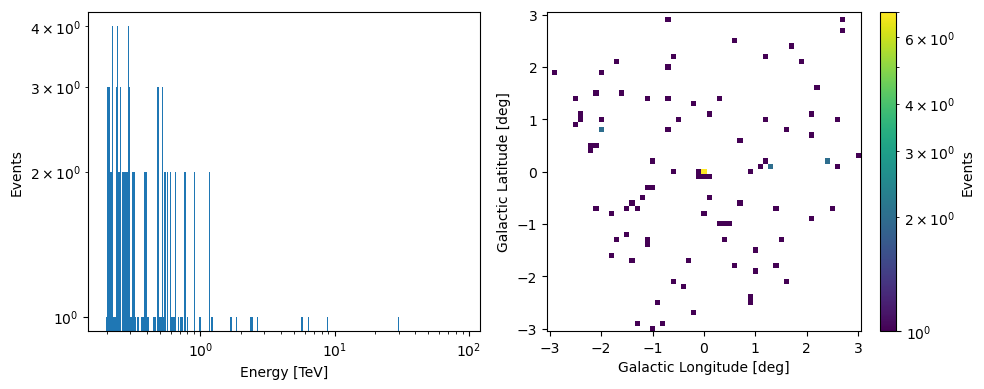

In [12]:
true_events.peek()
plt.show()

In [13]:
measured_event_data = irf_loglike.sample(true_events)

In [14]:
# measured_event_data.save("measured_data")

In [15]:
# measured_event_data.load("measured_data.h5")

# Nuisance Parameter Marg

In [16]:
from gammabayes.hyper_inference import DiscreteAdaptiveScan as discrete_scan_hyperparameter_likelihood
from gammabayes import ParameterSet

In [17]:
discrete_scan_hyperparameter_likelihood_instance = discrete_scan_hyperparameter_likelihood(
    log_priors=(DM_prior, ccr_bkg_prior, diffuse_astro_bkg_prior, point_astro_bkg_prior),
    log_likelihood=irf_loglike, 
    nuisance_axes = DM_prior.axes, 
    axes=irf_loglike.axes,
    prior_parameter_specifications=config_dict['parameter_specifications'], 
    log_likelihoodnormalisation=irf_norm_matrix,
    bounds=[['log10', 0.36], ['linear', 0.44], ['linear', 0.44]],
    mixture_fraction_exploration_type='sample')


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/hyper_inference/utils.py:50: UserWarning: 
You have specifed 3 less hyperparameter axes than priors. 
Assigning empty hyperparameter axes for remaining priors.
  warnings.warn(f"""


In [18]:
reshaped_log_marg_results = discrete_scan_hyperparameter_likelihood_instance.nuisance_log_marginalisation(
    measured_event_data=measured_event_data)

Setting up prior matrices: 100%|██████████| 4/4 [01:17<00:00, 19.33s/it]


In [19]:
mixture_parameter_set = ParameterSet(config_dict['mixture_fraction_specifications'])
prior_parameters = ParameterSet(config_dict['parameter_specifications'])

In [20]:
discrete_scan_hyperparameter_likelihood_instance.select_scan_output_posterior_exploration_class(
    log_nuisance_marg_results=reshaped_log_marg_results,
    mixture_parameter_specifications=mixture_parameter_set,
    prior_parameter_specifications = [ParameterSet(config_dict['parameter_specifications']),],
)

discrete_scan_hyperparameter_likelihood_instance.init_posterior_exploration()

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/hyper_inference/mixture_sampling_nuisance_scan_output.py:74: UserWarning: Number of mixtures +1 does not match number of 
priors indicated in log_nuisance_marg_results. Assigning min=0 and max=1 for remaining mixtures.
  warnings.warn("""Number of mixtures +1 does not match number of


In [21]:
discrete_scan_hyperparameter_likelihood_instance.run_posterior_exploration()

3479it [00:08, 397.27it/s, +500 | bound: 35 | nc: 1 | ncall: 43711 | eff(%):  9.208 | loglstar:   -inf < -849.450 <    inf | logz: -855.714 +/-  0.109 | dlogz:  0.001 >  0.509]


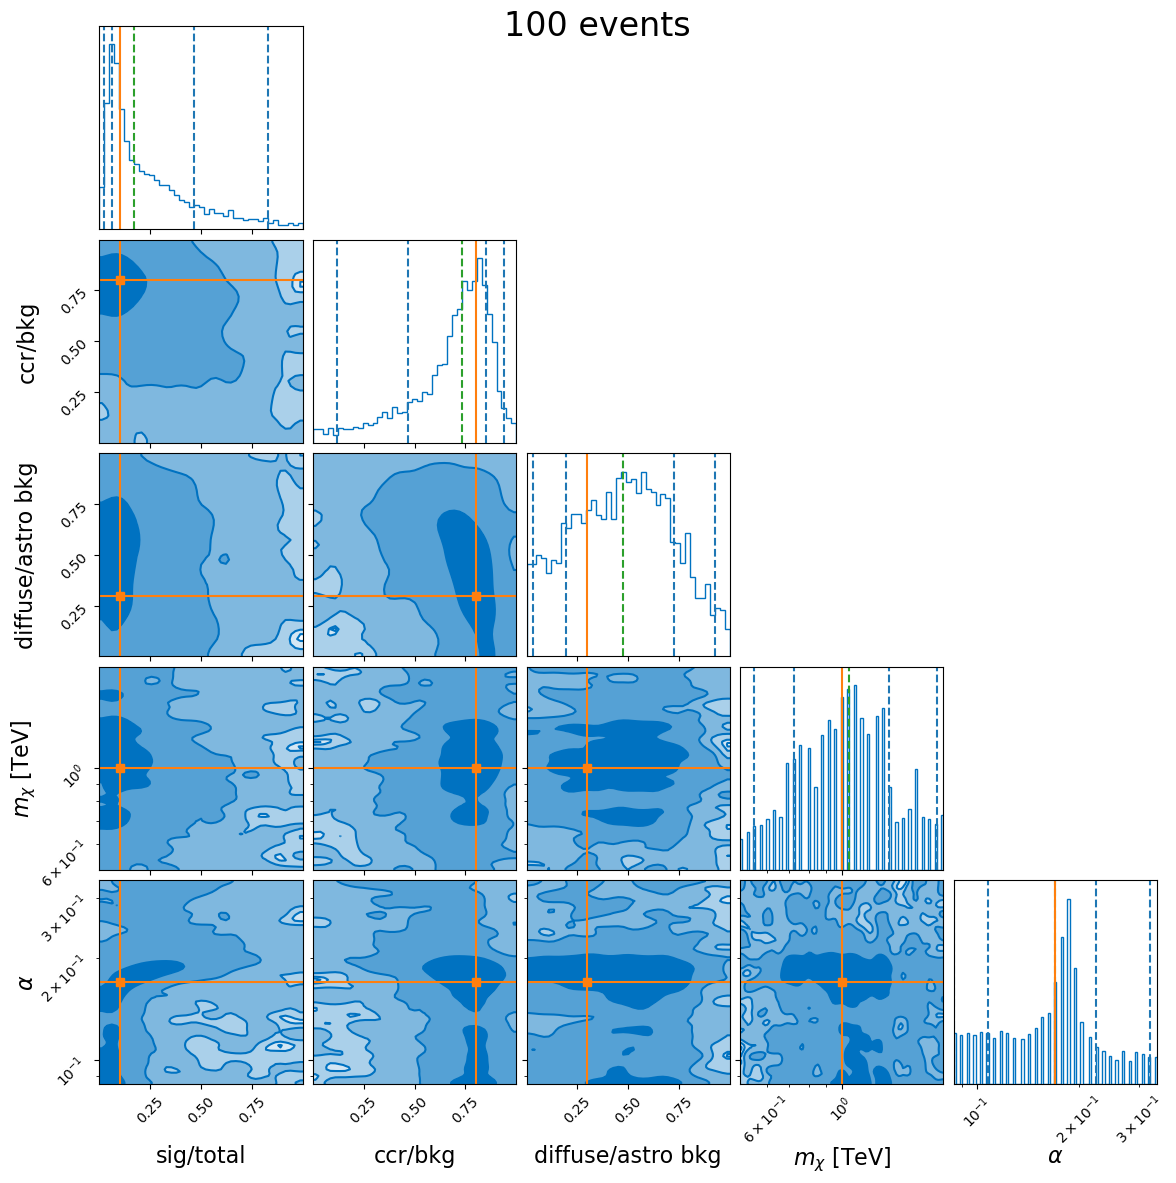

In [24]:
from corner import corner
from gammabayes.utils.plotting import defaults_kwargs
from scipy.special import logsumexp
defaults_kwargs['smooth'] = 2



num_params = 5
sampling_results = discrete_scan_hyperparameter_likelihood_instance.posterior_exploration_results
weights = np.exp(sampling_results.logwt - logsumexp(sampling_results.logwt))  # Calculate normalized weights

fig = plt.figure(figsize=(12,12))
figure=corner(sampling_results.samples, fig=fig,
       labels=['sig/total', 'ccr/bkg', 'diffuse/astro bkg', r'$m_{\chi}$ [TeV]', r'$\alpha$'],
       truths=[0.1,0.8, 0.3, 1.0, 0.17],
       quantiles=[0.025, .16, 0.5, .84, 0.975],
       bins=[41, 41, 41,*[axis.size*3 for axis in prior_parameters.axes]],
    #    range=([0.44,0.68], [0.7,0.9], [0.3,0.5], *[[axis.min(), axis.max()] for axis in prior_parameters.axes]),
       axes_scale=['linear', 'linear', 'linear', 'log', 'log'],
    
       **defaults_kwargs)

for ax_idx, ax in enumerate(figure.get_axes()):
    # Find lines representing the quantiles (the 3rd line for each histogram is the median, based on the ordering in `quantiles`)
    lines = ax.get_lines()
    if (len(lines) > 2):
        if (ax_idx%(num_params+1)==0): 
            for line_idx, line in enumerate(lines): # Check if there are enough lines (for histograms)
                if line_idx==2:
                    line.set_color('tab:green')  # Change the color of the median lines
                elif line_idx<len(lines)-1:
                    line.set_color('tab:blue')
plt.suptitle(str(measured_event_data.Nevents) + " events", size=24)


plt.show()


In [29]:
100/4*1e8/60/60/24/24/300

4.018775720164609